In [1]:
cd((@__DIR__) * raw"\..")
include("../table_reader.jl")

extract_series (generic function with 1 method)

In [2]:
series=extract_series("TX_STAID000031.txt",plot=false)
years=unique(Dates.year.(series.DATE))

#Imputing missing values
# include("utils/Missing_values.jl")
# ImputeMissingValues!(series[!,2],series.DATE)
# N=length(series[!,2])

107-element Vector{Int64}:
 1897
 1898
 1899
 1900
 1901
 1902
 1903
 1904
 1905
 1906
    ⋮
 1995
 1996
 1997
 1998
 1999
 2000
 2001
 2002
 2003

## I. Series filtered by removing a trigonometric periodicity

In [3]:
include("../utils/periodicity.jl")
trigo_function=fitted_periodicity_fonc(series[!,2],series.DATE)
periodicity=trigo_function.(series.DATE)
x=series[!,2]-periodicity
period=trigo_function.(Date(0):Date(1)-Day(1))

366-element Vector{Float64}:
 11.528956959626012
 11.479482070278829
 11.432402944839923
 11.387733515374967
 11.345487000851369
 11.305675903226405
 11.268312003747525
 11.233406359465945
 11.200969299964553
 11.171010424301087
  ⋮
 12.025920462572222
 11.957320963539608
 11.890975822159755
 11.826904671865908
 11.765126473152028
 11.705659507961837
 11.648521374278655
 11.593728980917659
 11.541298542522082

## Segmenting the dataset by month

In [4]:
include("../utils/Separation.jl")
Monthly_date=MonthlySeparateDates(series.DATE)
Monthly_temp=MonthlySeparateX(x,series.DATE)

12-element Vector{Vector{AbstractVector}}:
 [[0.07104304037398812, 0.8205179297211718, 1.5675970551600766, -1.1877335153749673, 2.654512999148631, 0.29432409677359495, 4.231687996252475, 3.866593640534054, 3.499030700035446, 4.628989575698913  …  -2.007288483956472, -8.510082906974825, -11.01541200259843, -7.2232741937948015, -0.6336671539157042, -0.14658780738567856, -5.962032330612191, -5.979996153117135, -3.6004739588893795, -5.123459687957929], [-0.22895695962601081, 0.9205179297211714, 4.267597055160076, 2.712266484625033, 2.5545129991486313, 0.8943240967735946, 1.1316879962524755, 1.5665936405340553, 1.199030700035447, 1.9289895756989122  …  2.992711516043528, 5.089917093025177, 1.1845879974015698, 4.476725806205199, 1.4663328460842955, 1.6534121926143204, 3.7379676693878103, 1.6200038468828648, -0.4004739588893802, 4.876540312042071], [-1.7289569596260108, 3.7205179297211703, -2.3324029448399237, 0.4122664846250341, 4.35451299914863, 4.094324096773596, 2.831687996252475, 3.06659

## Autocorrelations

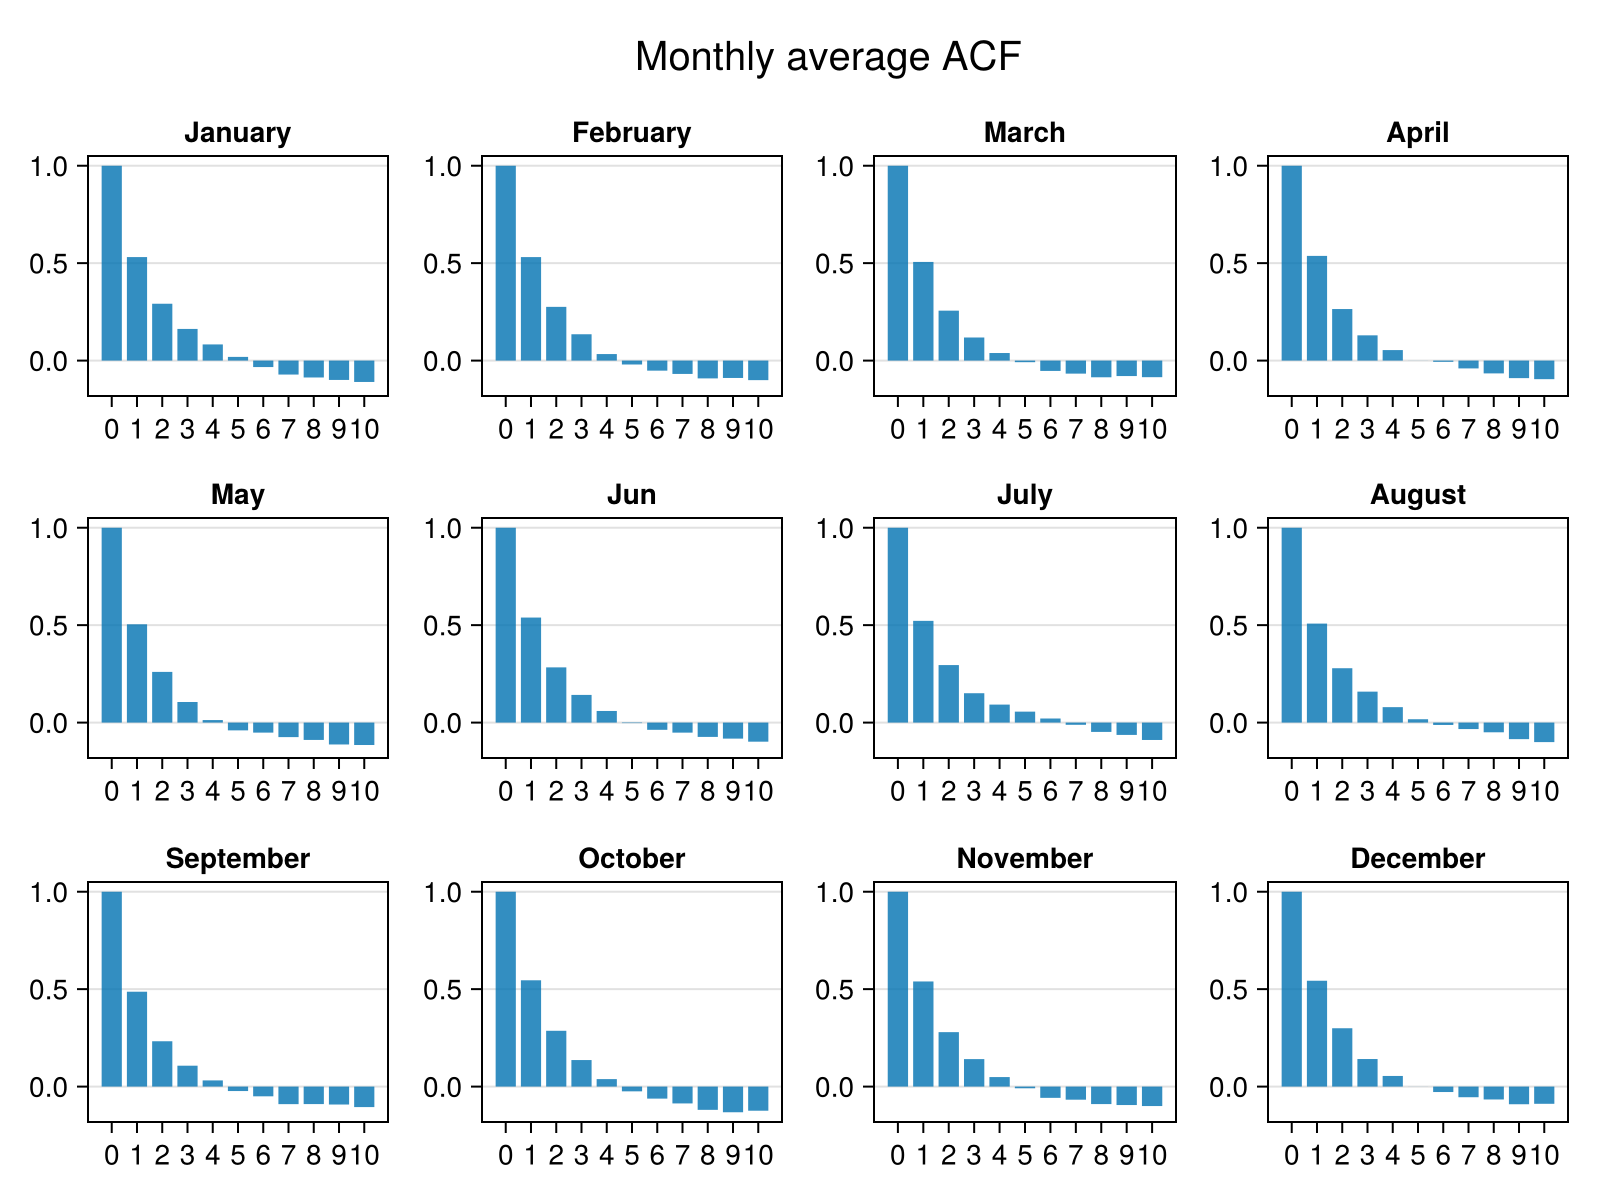

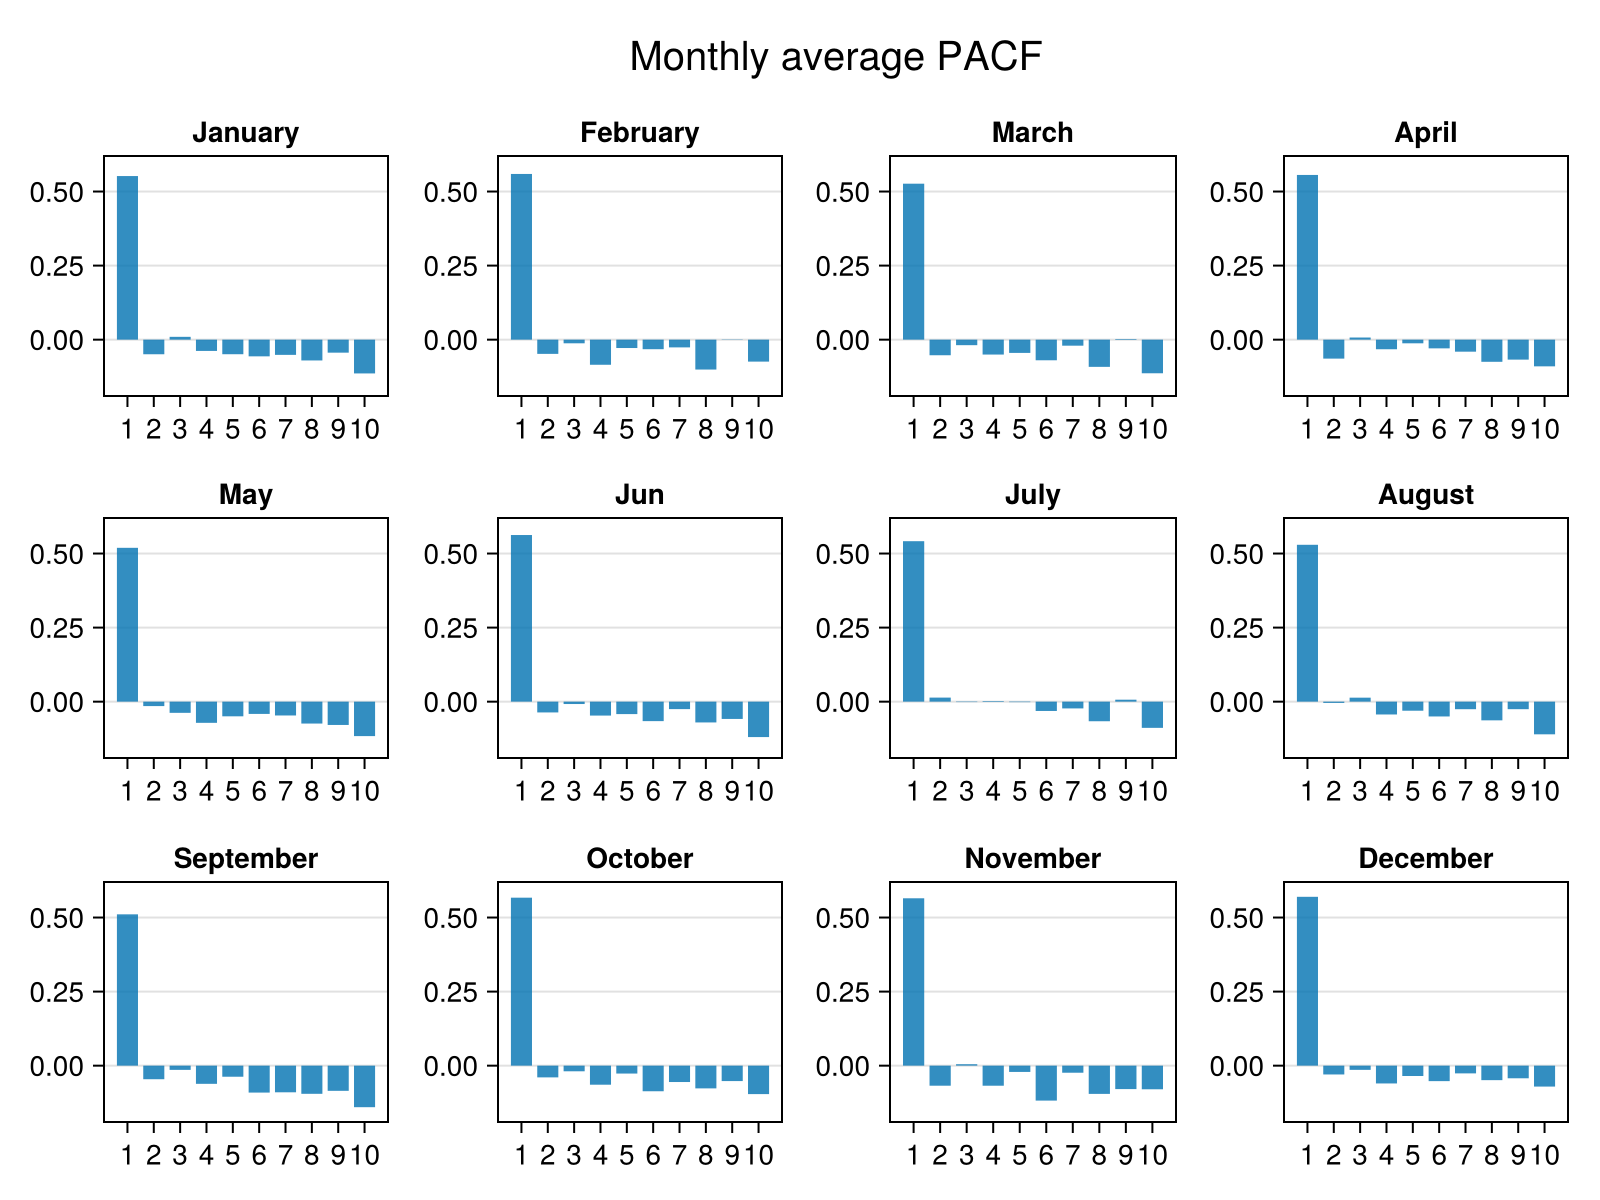

CairoMakie.Screen{IMAGE}


In [5]:
include("../utils/ACF_PACF.jl")
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

For each month, it still looks like an AR(1) model

# Estimation AR(1)

## Estimation

ERROR: LoadError: too many parameters for type AbstractInterpolation
Stacktrace:
 [1] top-level scope
   @ C:\Users\goninarn\.julia\packages\SparseConnectivityTracer\litqn\ext\SparseConnectivityTracerDataInterpolationsExt.jl:28
 [2] include
   @ .\Base.jl:557 [inlined]
 [3] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base .\loading.jl:2881
 [4] top-level scope
   @ stdin:6
in expression starting at C:\Users\goninarn\.julia\packages\SparseConnectivityTracer\litqn\ext\SparseConnectivityTracerDataInterpolationsExt.jl:3
in expression starting at stdin:6
┌ Error: Error during loading of extension SparseConnectivityTracerDataInterpolationsExt of SparseConnectivityTracer, use `Base.retry_load_extensions()` to retry.
│   exception = 1-element ExceptionStack:
Failed to precompile SparseConnectivityTracerDataInterpolationsExt [

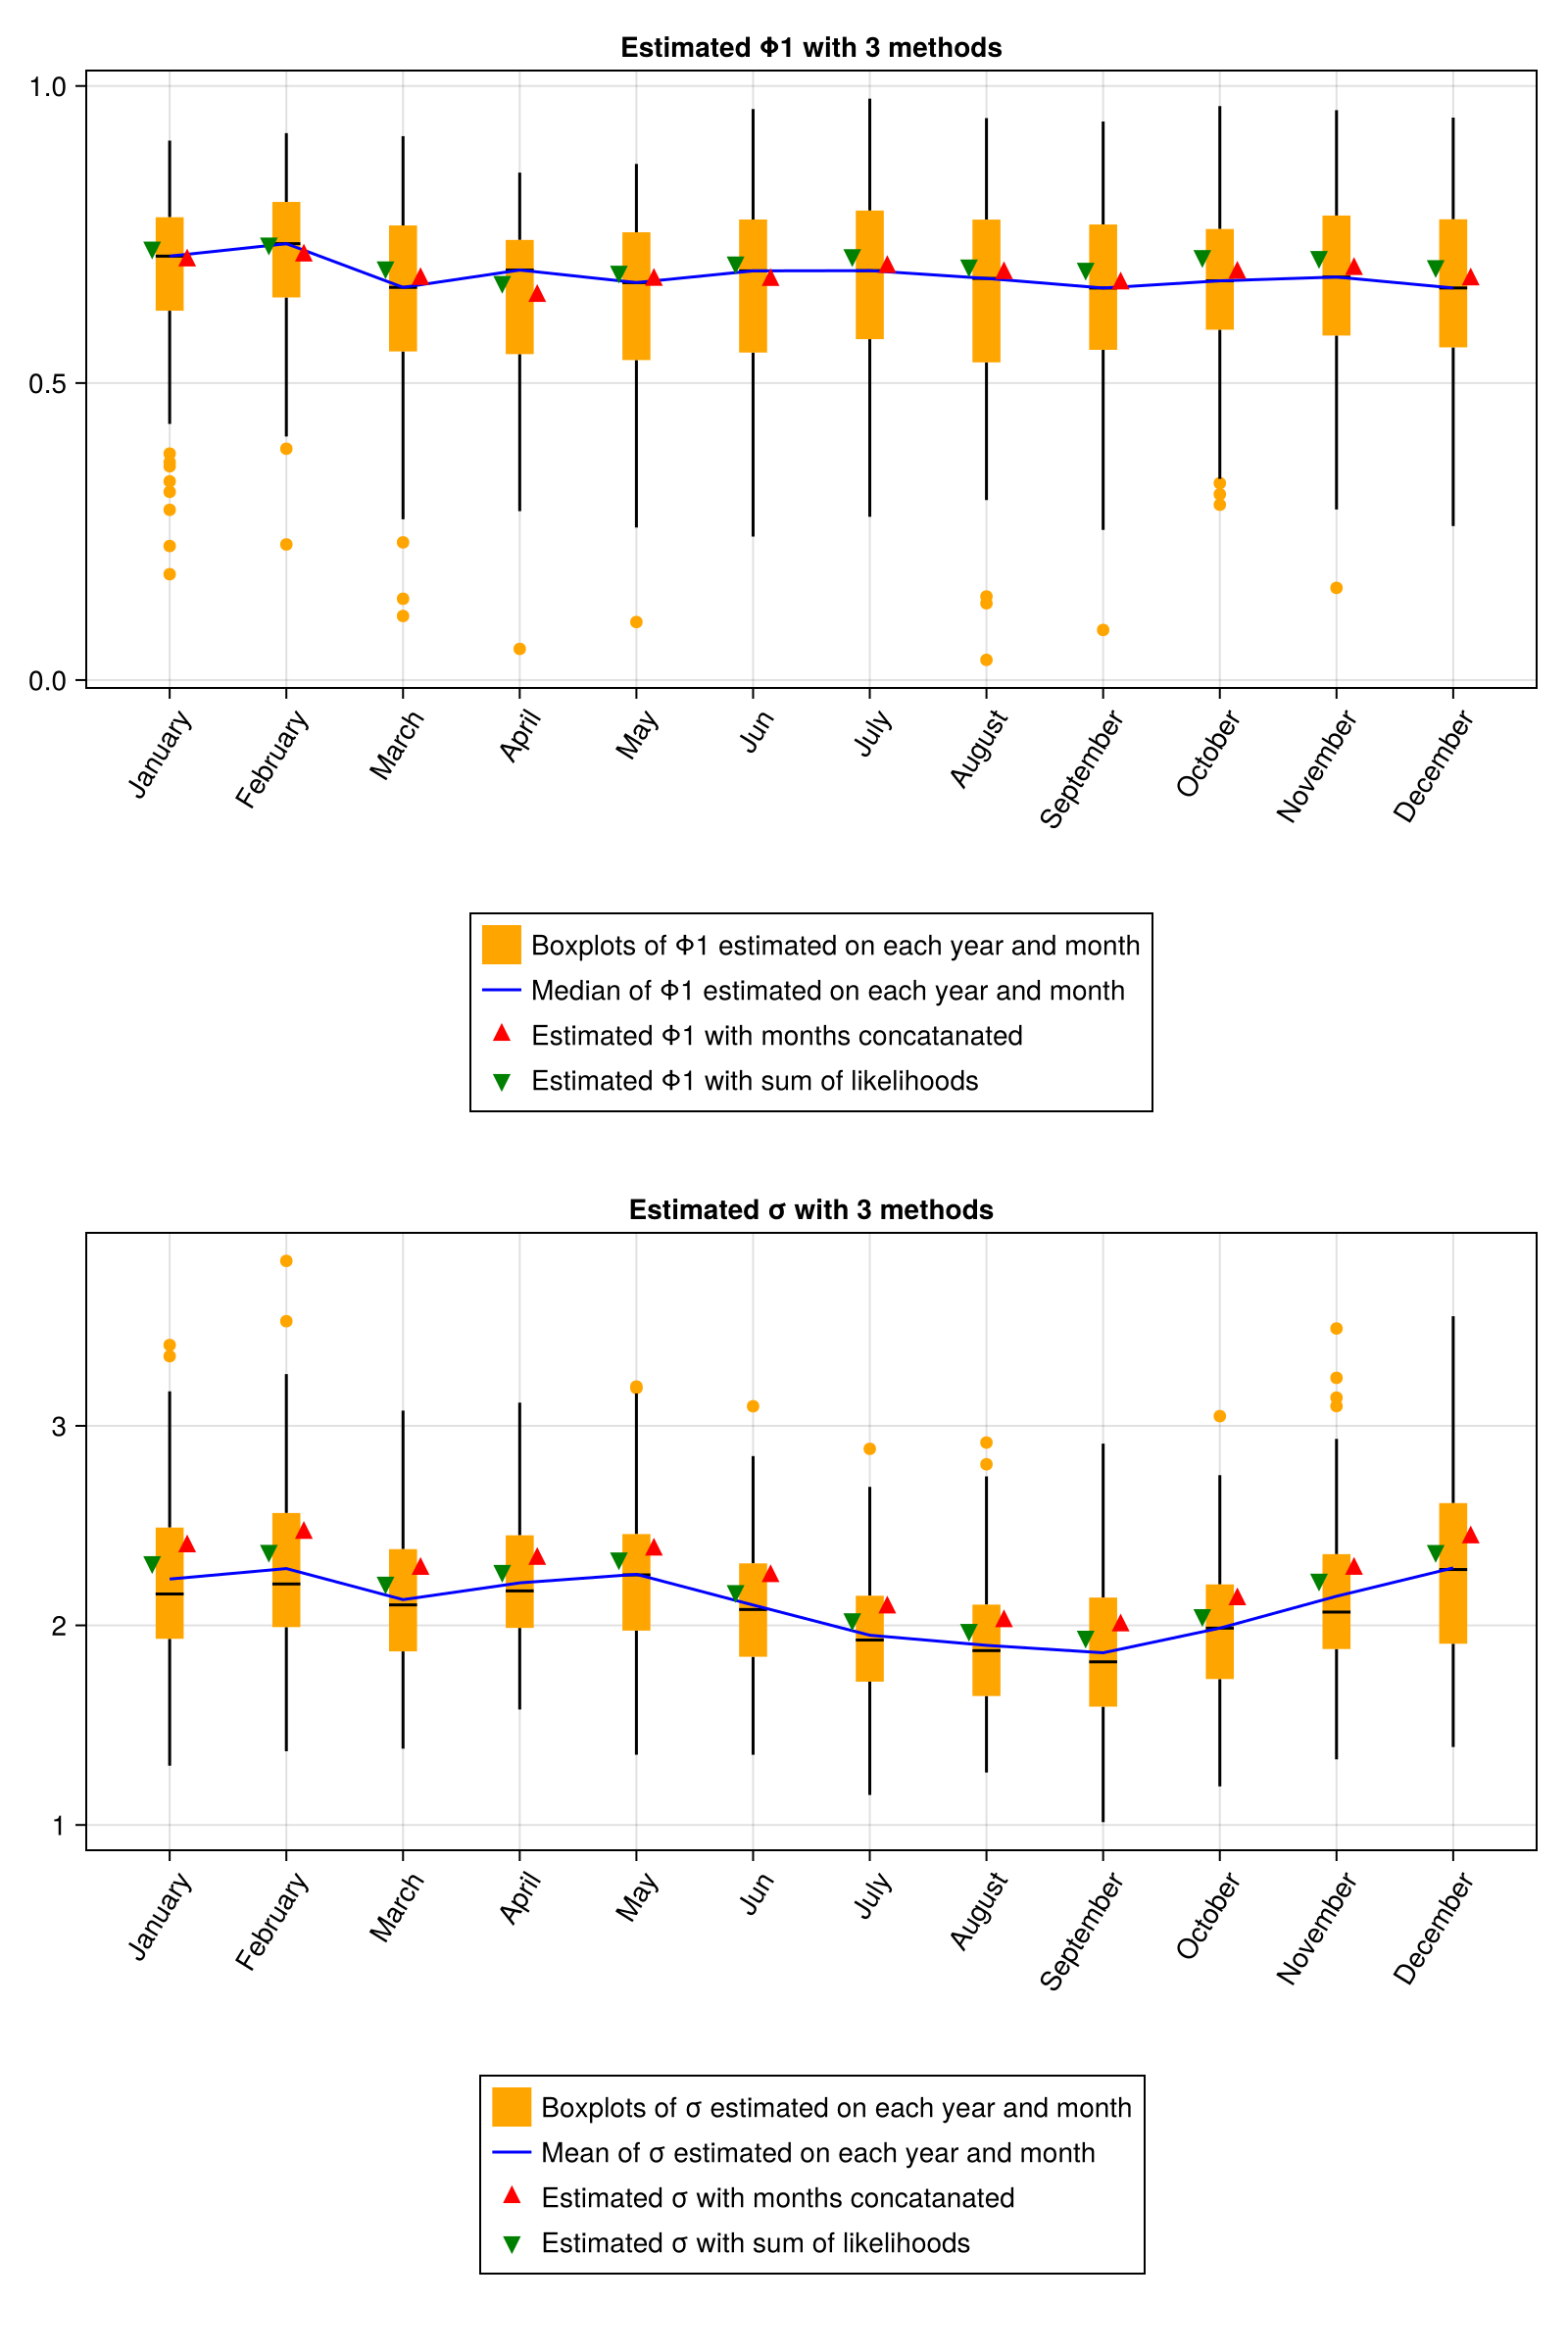

CairoMakie.Screen{IMAGE}


In [6]:
include(raw"..\utils\Estimation.jl")
Params, figure= AllEstimation(Monthly_temp, lineplot=true)
display(figure)

## Simulation

### With estimation on each month

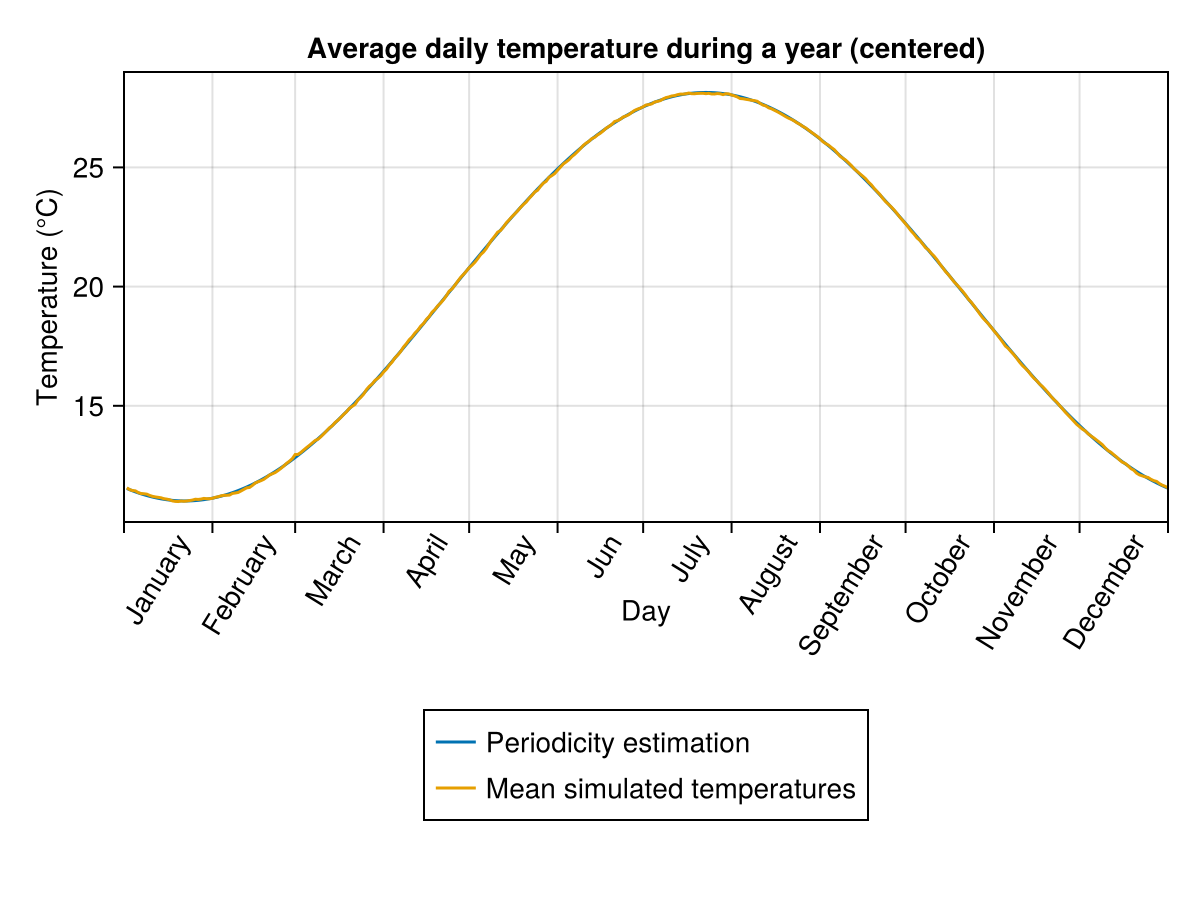

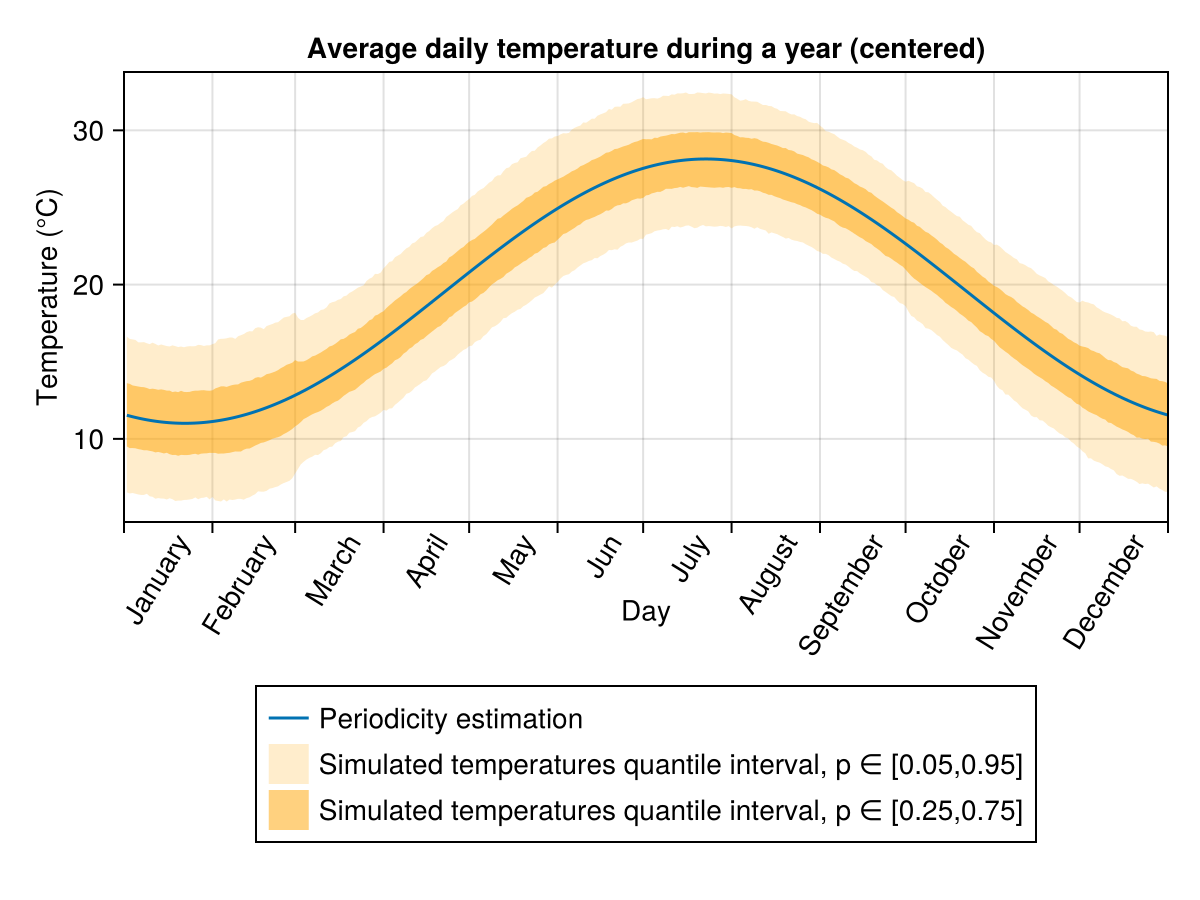

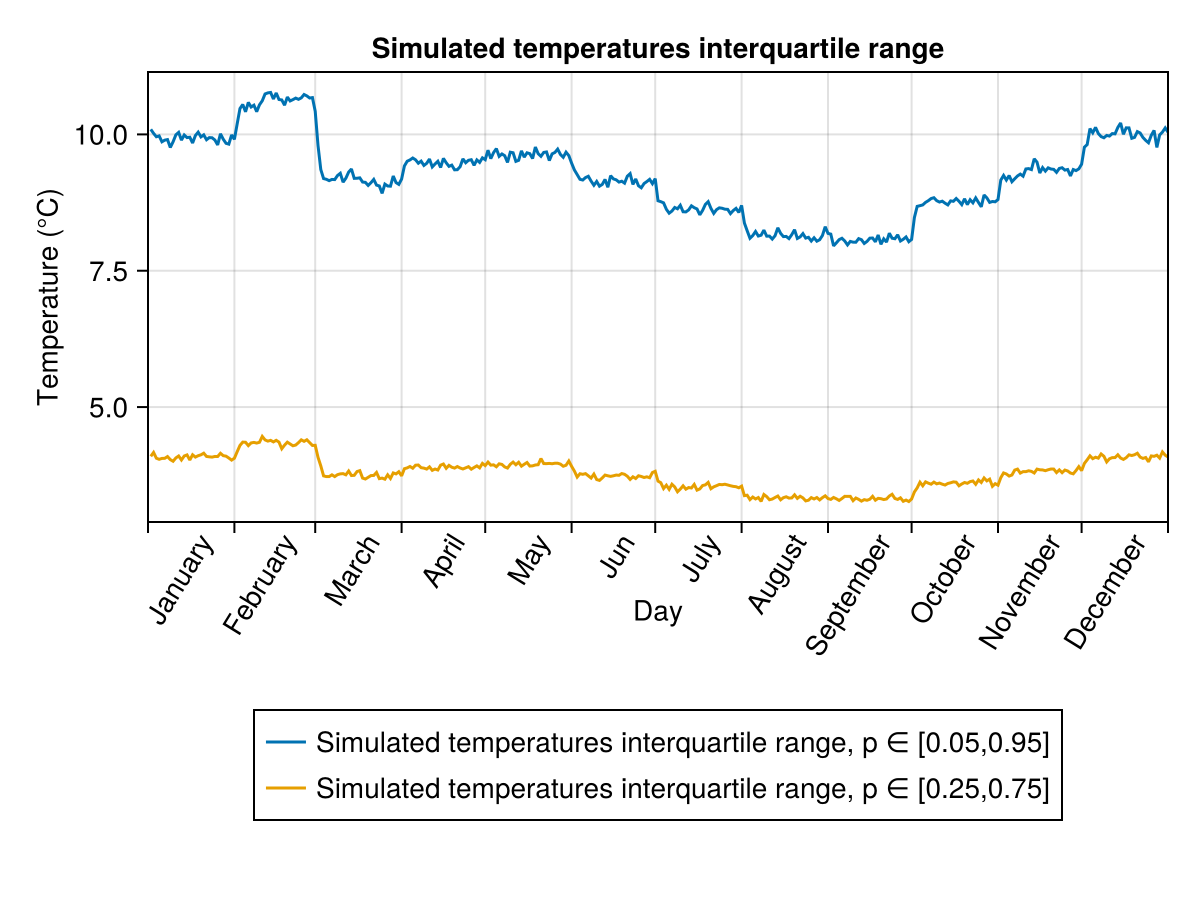

CairoMakie.Screen{IMAGE}


In [7]:
include("../utils/Simulation.jl")
include("../utils/Plotting.jl")
Φ_month_mean,σ_month_mean=TakeParameters(Params,"mean")
sample_ = GatherYearScenarios(SimulateScenarios(Monthly_temp[1][1][1],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=100),series.DATE[1]:series.DATE[end])
display(PlotYearCurves([period,mean.(sample_)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Periodicity estimation","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

We see clearly that interquartile range is shorter during summer and larger during winter.

### With months concatanation

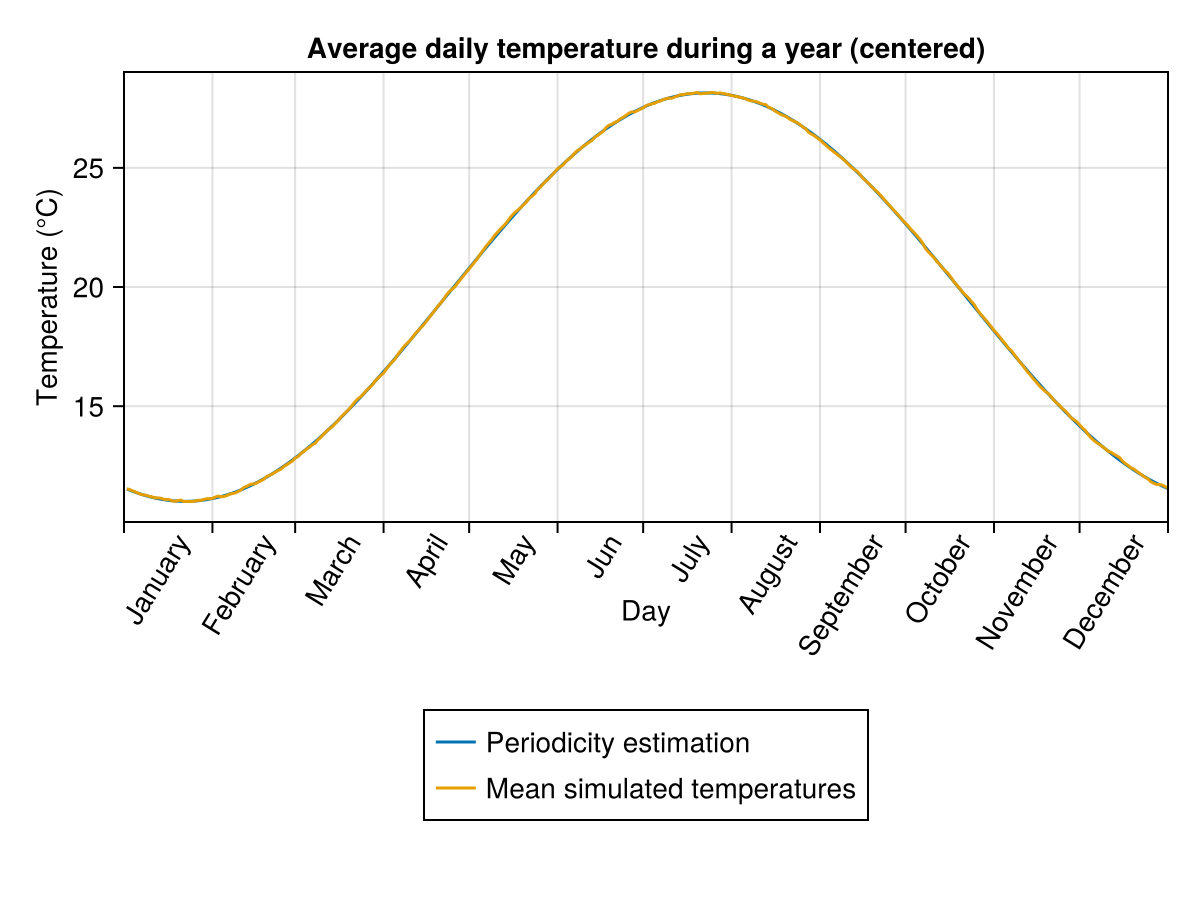

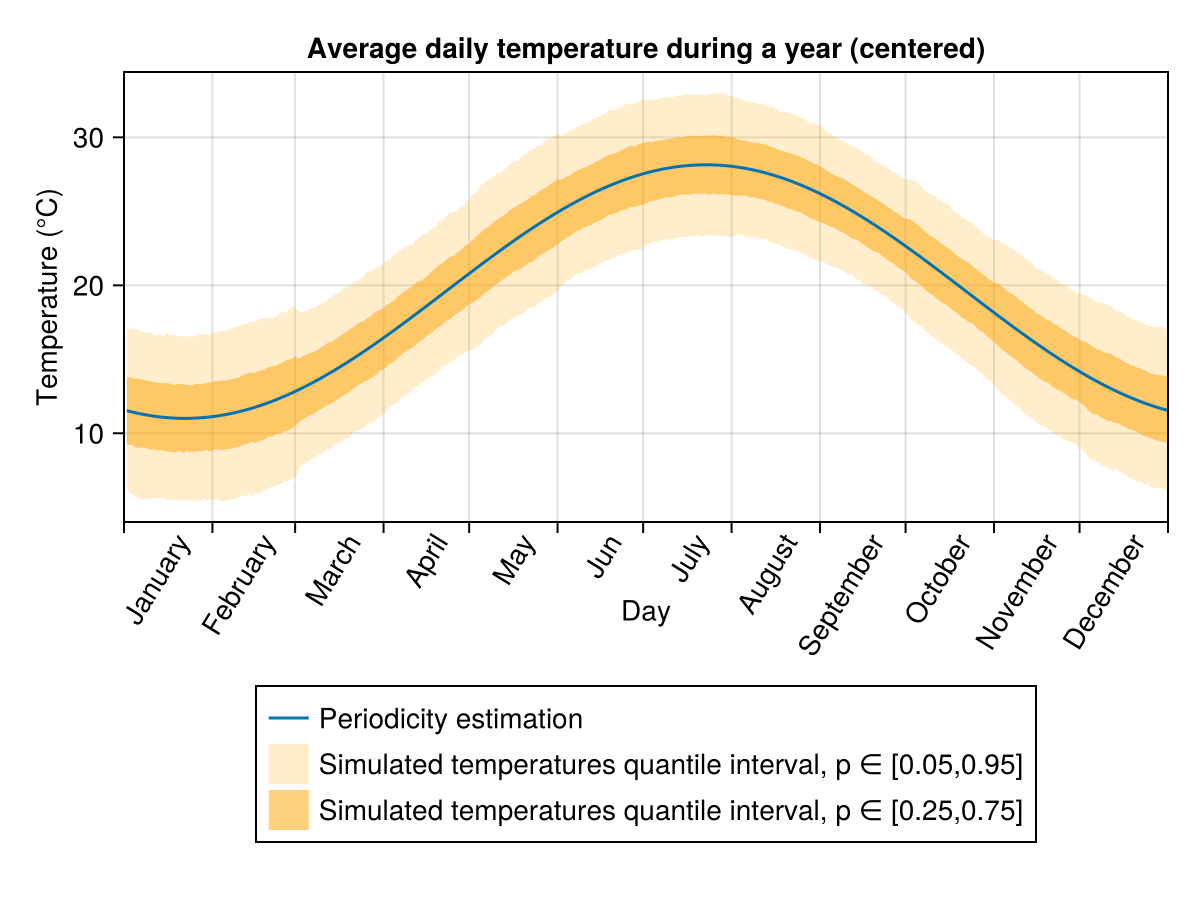

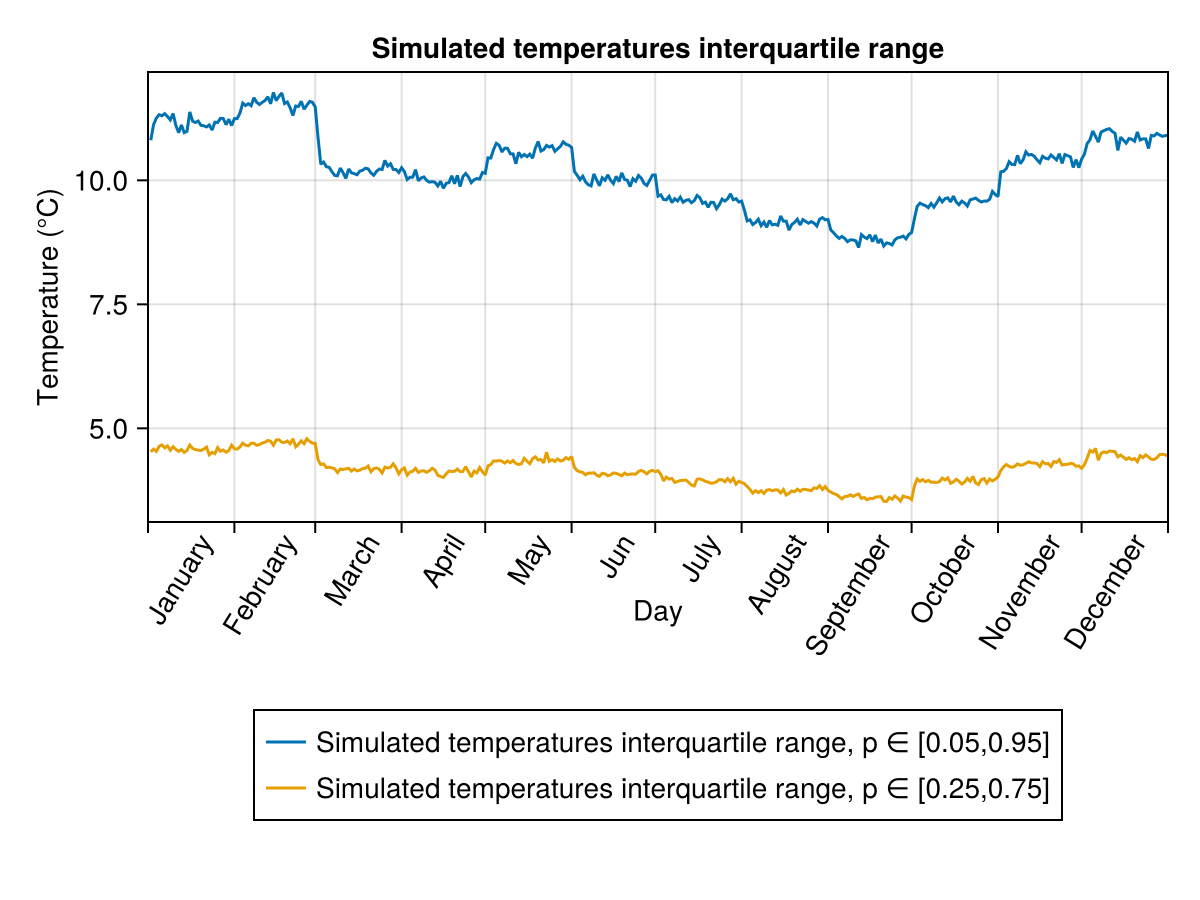

CairoMakie.Screen{IMAGE}


In [8]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"concat")
sample_ = GatherYearScenarios(SimulateScenarios(Monthly_temp[1][1][1],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=100),series.DATE[1]:series.DATE[end]) 
display(PlotYearCurves([period,mean.(sample_)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Periodicity estimation","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

### With sum of likelihoods

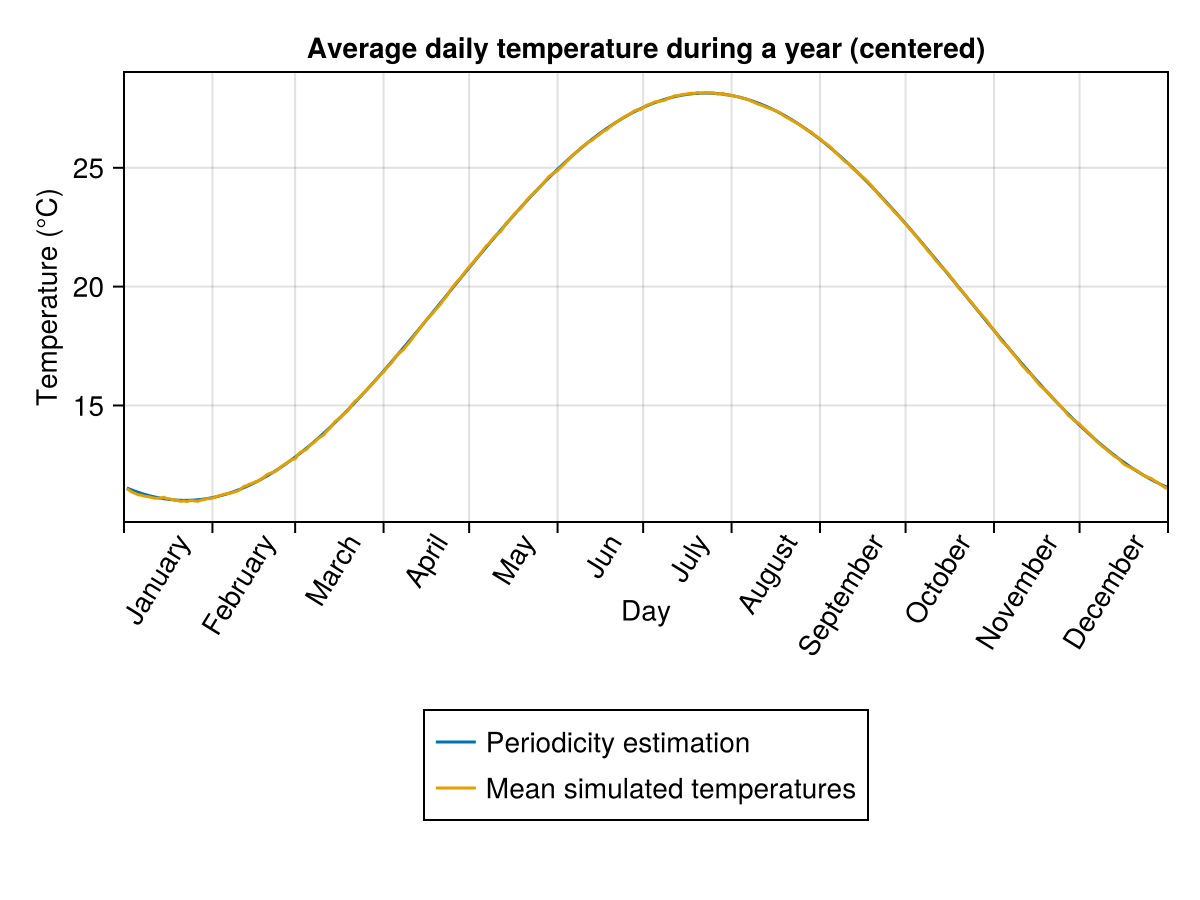

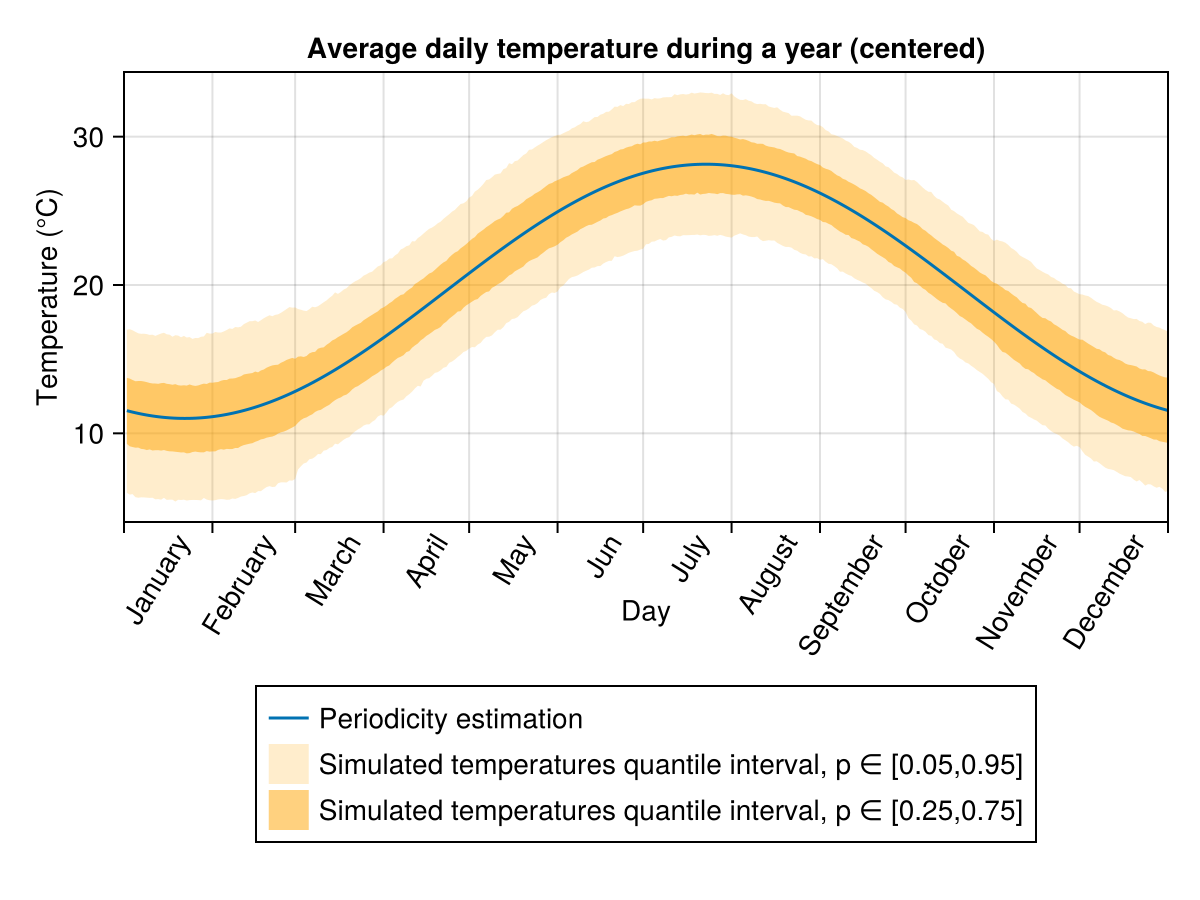

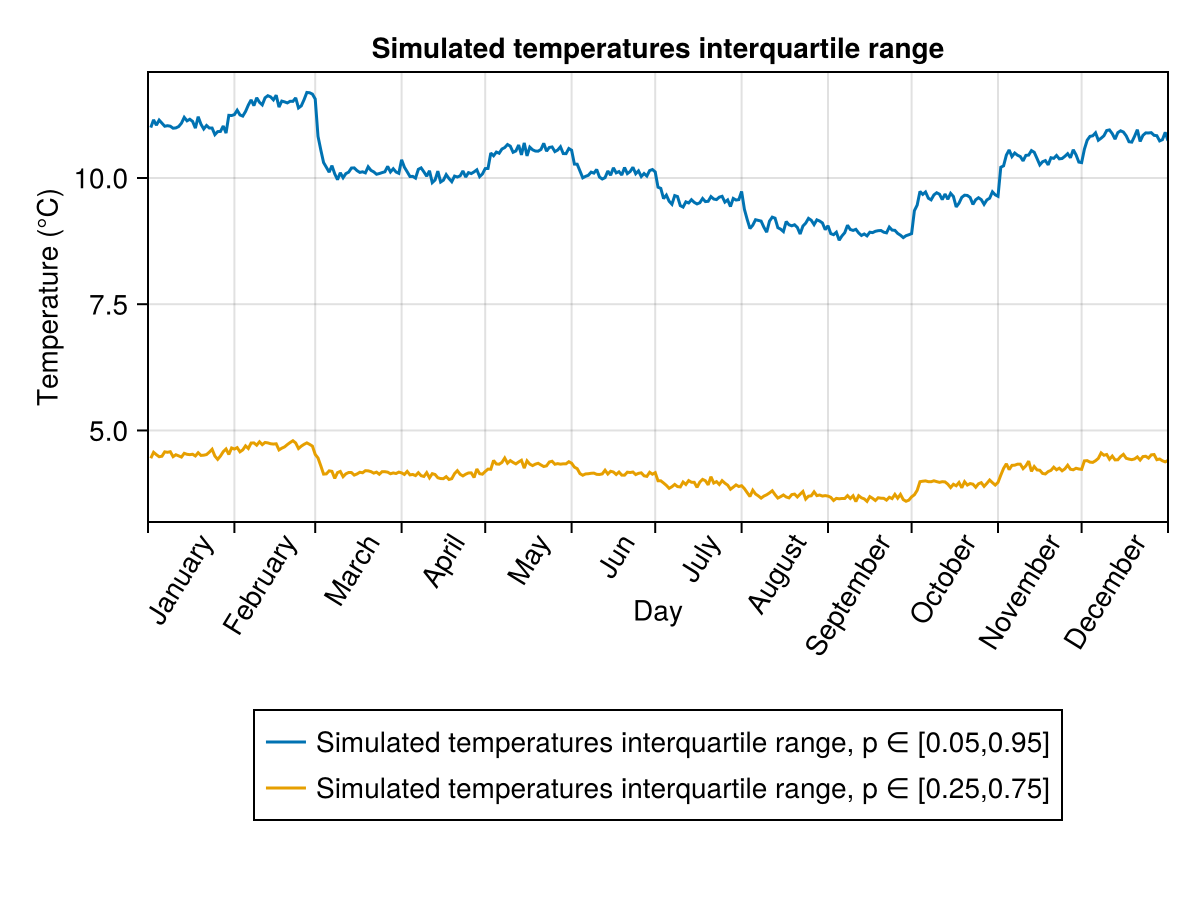

CairoMakie.Screen{IMAGE}


In [9]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"sumLL")
sample_ = GatherYearScenarios(SimulateScenarios(Monthly_temp[1][1][1],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=100),series.DATE[1]:series.DATE[end])
display(PlotYearCurves([period,mean.(sample_)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Periodicity estimation","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

# Estimation AR(2)

## Estimation

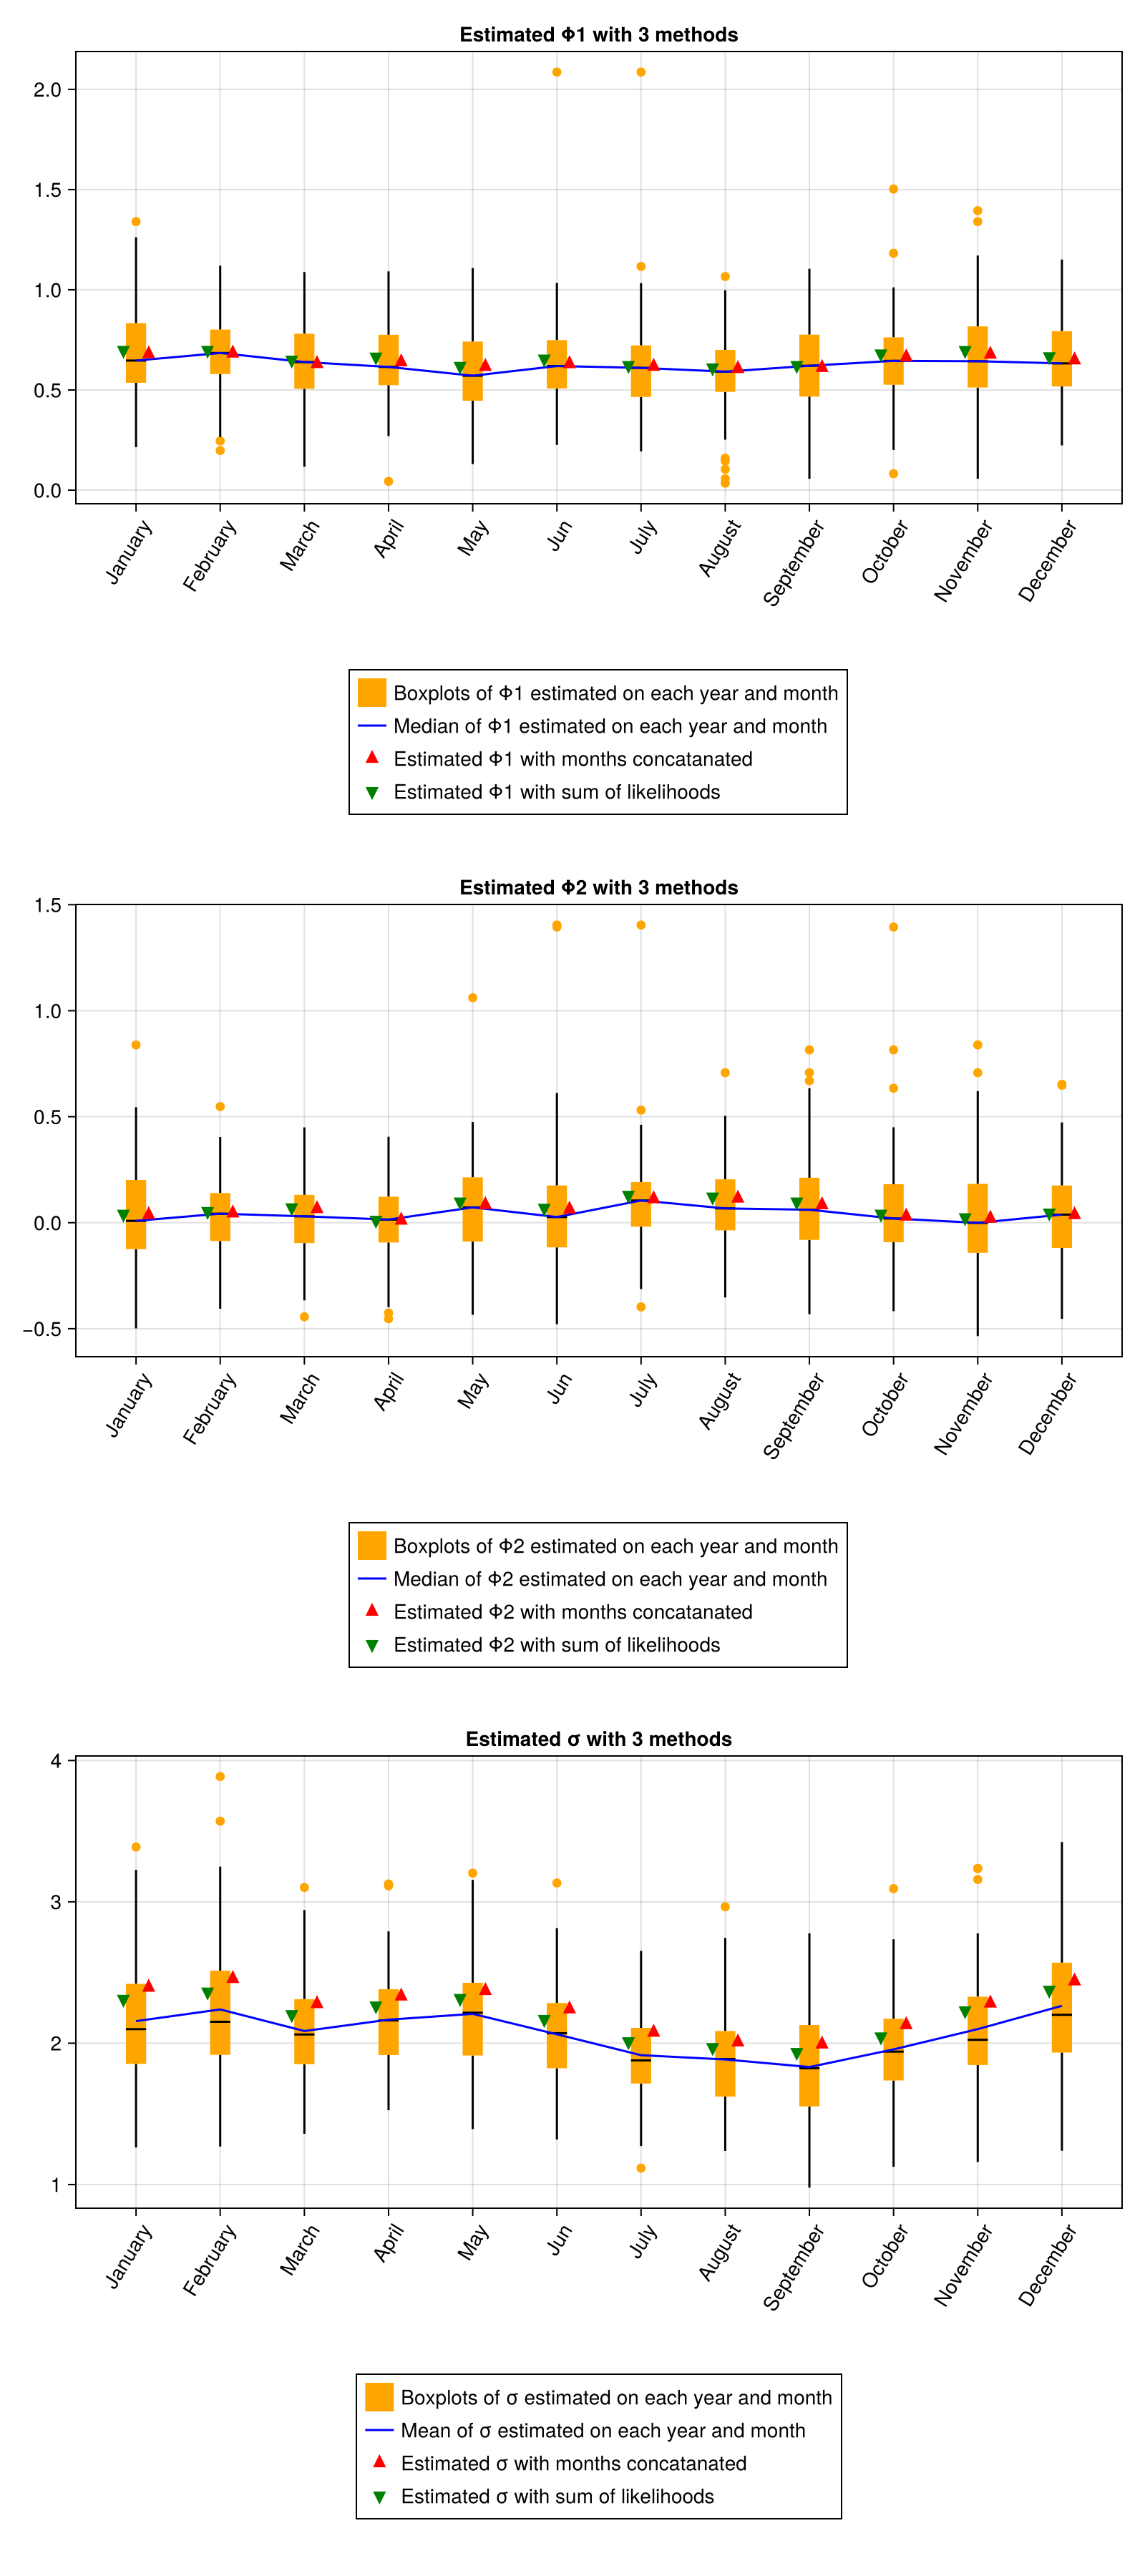

CairoMakie.Screen{IMAGE}


In [10]:
include("../utils/Estimation.jl")
Params, figure= AllEstimation(Monthly_temp, 2, lineplot=true)
display(figure)

### Estimation and simulation with sum of likelihoods

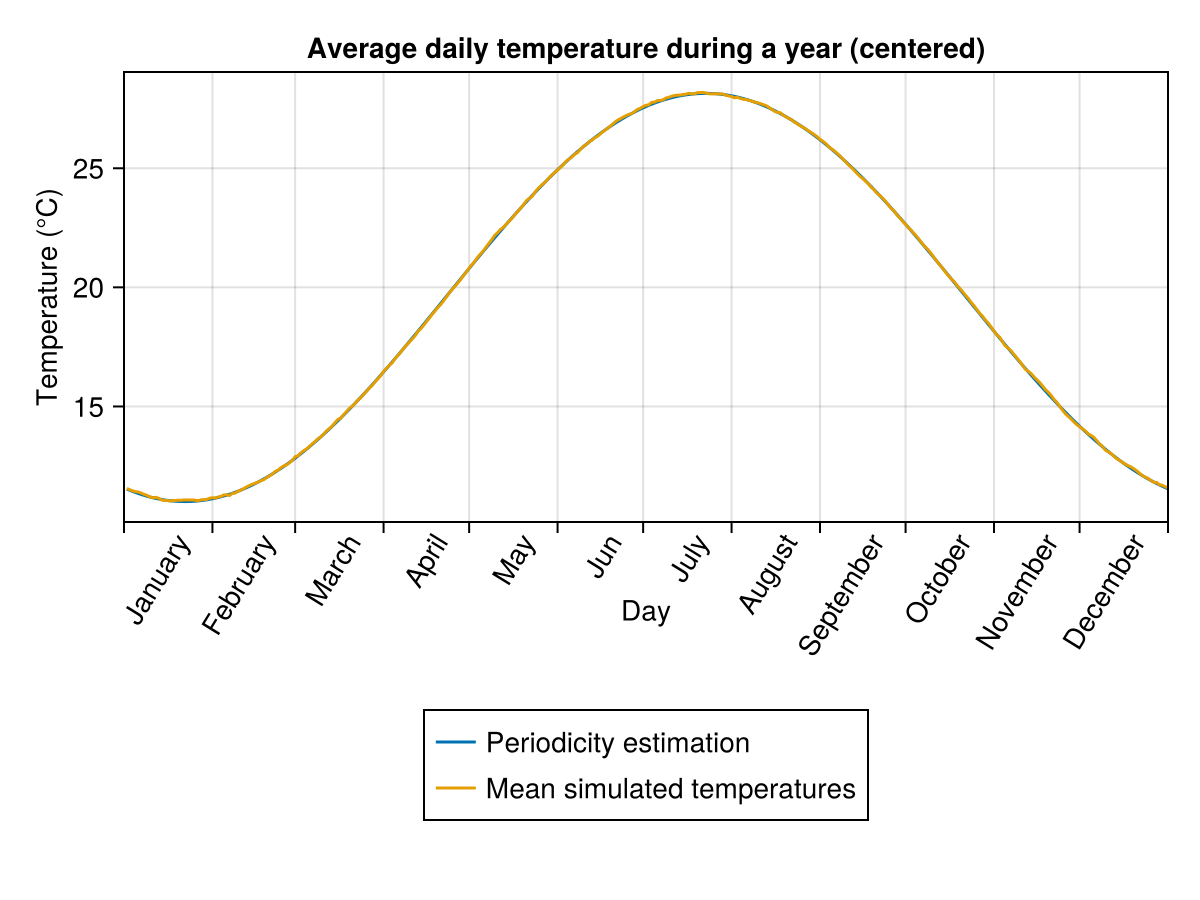

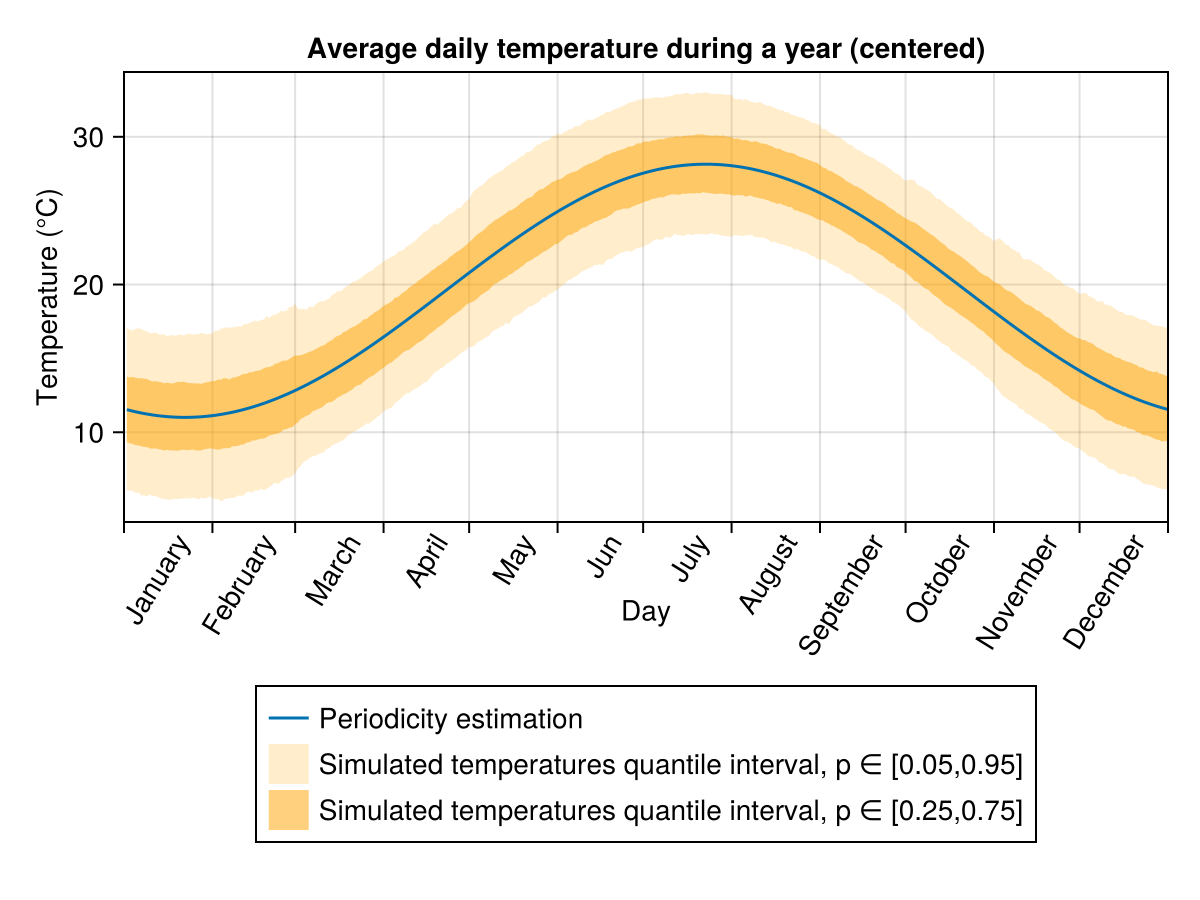

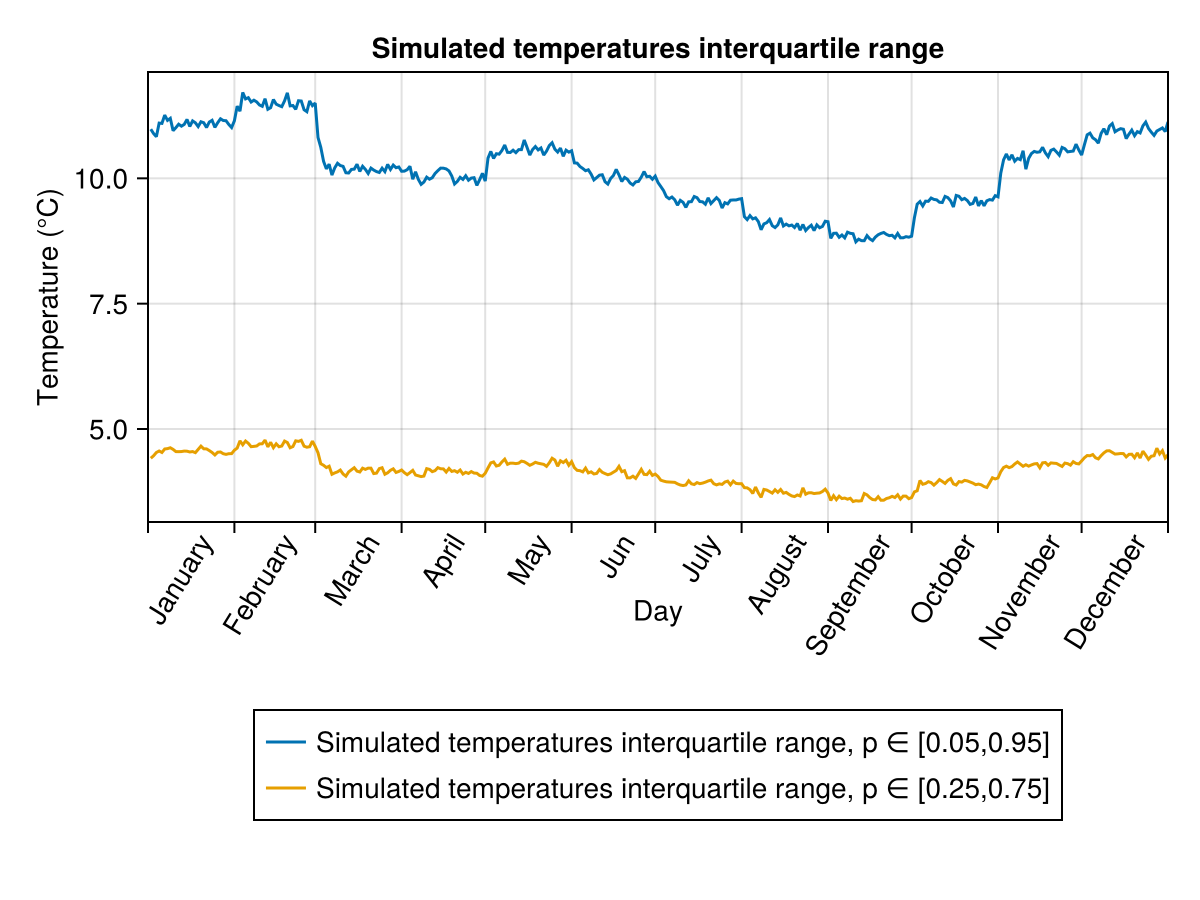

CairoMakie.Screen{IMAGE}


In [11]:
Φ_month_mean,σ_month_mean=TakeParameters(Params,"sumLL")
sample_ = GatherYearScenarios(SimulateScenarios(Monthly_temp[1][1][1:2],series.DATE[1]:series.DATE[end],Φ_month_mean,σ_month_mean,period,n=100),series.DATE[1]:series.DATE[end])
display(PlotYearCurves([period,mean.(sample_)],["Periodicity estimation","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Periodicity estimation","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))